# Credit Risk Modeling: LGD & EAD Model


## 1. Import Libraries and Data

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
data = pd.read_csv('/content/cleaned_loan_data_2007-2014_defaults.csv')
df = data.copy()

## 2. Explore Data

In [11]:
df.columns.values

array(['loan_amnt', 'funded_amnt', 'revol_bal', 'status',
       'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'grade', 'sub_grade',
       'home_ownership', 'verification_status', 'issue_d', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'emp_length_int',
       'isThreeYearsTerm', 'Payment_Plan', 'Initial_Status'], dtype=object)

In [17]:
df.drop(columns=['status'], inplace=True)
df.drop(columns=['grade', 'zip_code'], inplace=True)

In [19]:
df.head(5)

,loan_amnt,funded_amnt,revol_bal,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,home_ownership,verification_status,issue_d,purpose,addr_state,earliest_cr_line,emp_length_int,isThreeYearsTerm,Payment_Plan,Initial_Status
0,2500.0,2500.0,1687.0,2500.0,15.27,59.83,30000.0,1.00,0.0,5.0,...,RENT,Source Verified,71.868852,car,GA,223.573770,0.0,0,0,0
1,5600.0,5600.0,5210.0,5600.0,21.28,152.39,40000.0,5.55,0.0,2.0,...,OWN,Source Verified,71.868852,small_business,CA,163.672131,4.0,0,0,0
2,5375.0,5375.0,9279.0,5350.0,12.69,121.45,15000.0,18.08,0.0,0.0,...,RENT,Verified,71.868852,other,TX,158.655738,0.0,0,0,0
3,9000.0,9000.0,10452.0,9000.0,13.49,305.38,30000.0,10.08,0.0,1.0,...,RENT,Source Verified,71.868852,debt_consolidation,VA,163.672131,0.0,1,0,0
4,10000.0,10000.0,11997.0,10000.0,10.65,325.74,100000.0,7.06,0.0,2.0,...,RENT,Source Verified,71.868852,other,CA,318.393443,3.0,1,0,0


# LGD model

## Dependent Variable

In [41]:
# The dependent variable for the LGD model: recovery rate
# = the ratio of recoveries and funded amount
df['recovery_rate'] = df['recoveries'] / df['funded_amnt']
df.drop('recoveries', axis=1, inplace=True)
df['recovery_rate'].describe()

<ipython-input-41-8f81f1e30bde>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('recoveries', axis=1, inplace=True)


,recovery_rate
count,50941.000000
mean,0.051048
std,0.082170
min,0.000000
25%,0.000000
50%,0.000000
75%,0.101524
max,1.000000


In [44]:
df['recovery_rate'][df['recovery_rate']>1].count()

0

In [23]:
df = df[df['recovery_rate']<=1]

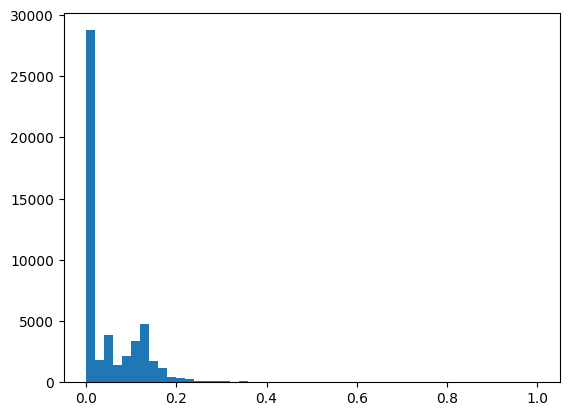

In [43]:
plt.hist(df['recovery_rate'], bins = 50);

In [26]:
categorical = df.select_dtypes('O').columns.values
categorical

array(['sub_grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state'], dtype=object)

In [45]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = df.drop('recovery_rate', axis=1)  # Features
y = df['recovery_rate']

# Convert categorical columns to 'category' dtype
for col in categorical:
    X[col] = X[col].astype('category')

# Replace infinite values with a large finite value
X.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost regressor with categorical feature handling
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=100,
                                 max_depth=5,
                                 learning_rate=0.1,
                                 enable_categorical=True,
                                 tree_method="hist")

xgb_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# R-squared score
r2_score = xgb_regressor.score(X_test, y_test)
print(f"R-squared: {r2_score}")

Mean Absolute Error: 0.006220688780051843
R-squared: 0.9460392404994502


In [57]:
y_pred

array([ 0.05251863,  0.00141259,  0.00012609, ..., -0.0003242 ,
        0.00371838, -0.00018192], dtype=float32)

In [58]:
y_test

,recovery_rate
28477,0.049696
29029,0.000000
35239,0.000000
13582,0.139006
22837,0.092662
...,...
2300,0.111507
12567,0.000000
45607,0.000000
2187,0.002856


# Model Evaluation

### Actual vs Predicted

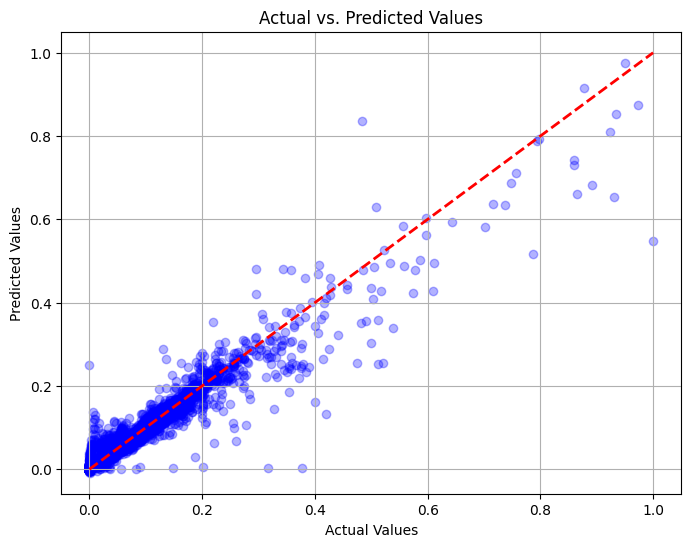

In [46]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

### Risiduals

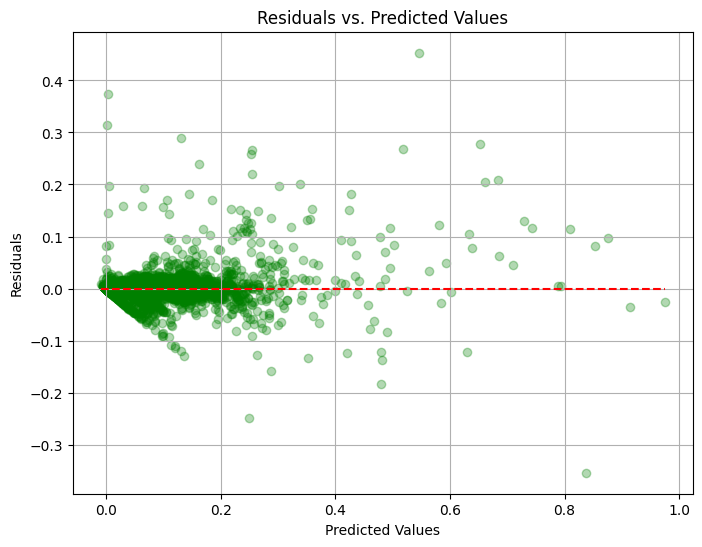

In [47]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.3, color='g')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.grid(True)
plt.show()


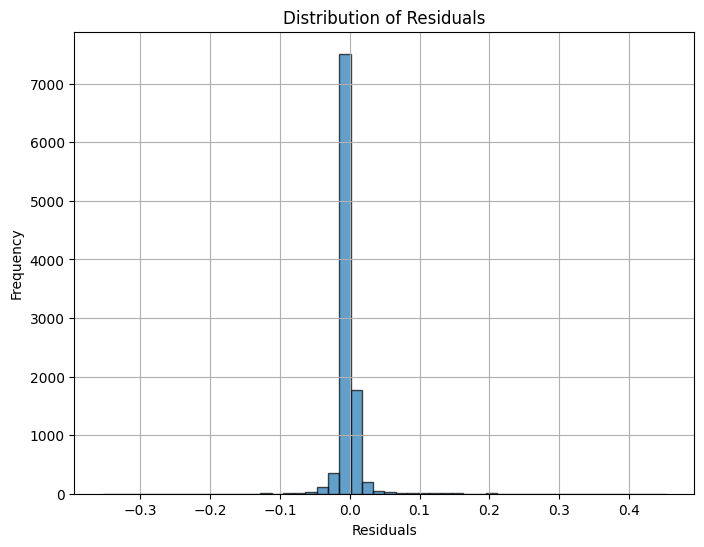

In [48]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

## Model Interpretation

### Feature importance

<Figure size 1200x800 with 0 Axes>

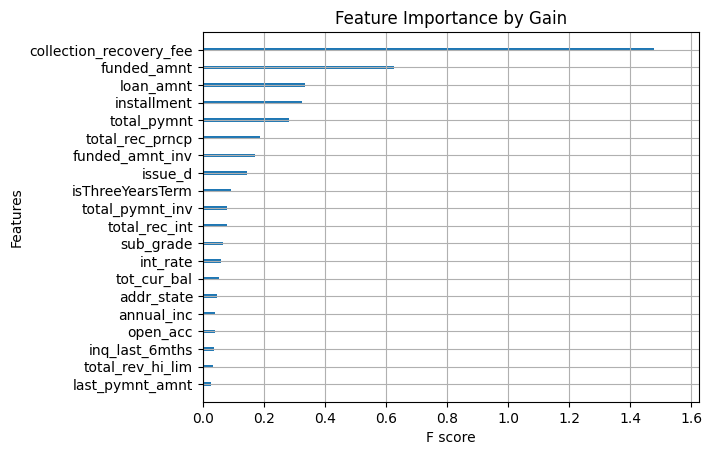

In [49]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_regressor, max_num_features=20, importance_type='gain', show_values=False)
plt.title('Feature Importance by Gain')
plt.show()


# EAD model

In [59]:
# The dependent variable for the EAD model: credit conversion factor.
# =the ratio of the difference of the amount
#  used at the moment of default to the total funded amount.
df['CCF'] = (df['funded_amnt'] - df['total_rec_prncp']) / df['funded_amnt']
df['CCF'].describe()

<ipython-input-59-d40d86ec72f9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CCF'] = (df['funded_amnt'] - df['total_rec_prncp']) / df['funded_amnt']


,CCF
count,50941.000000
mean,0.719193
std,0.204761
min,0.000000
25%,0.608252
50%,0.769320
75%,0.876578
max,1.000000


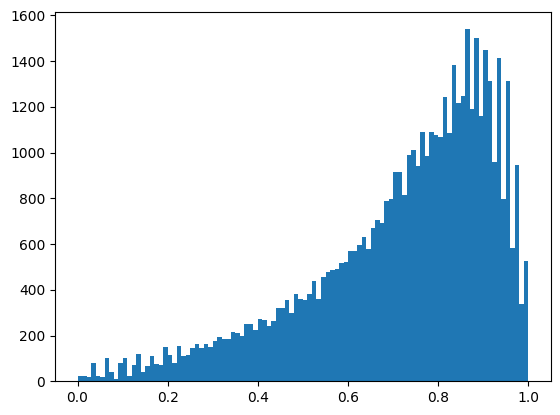

In [60]:
plt.hist(df['CCF'], bins = 100);

# Expected Loss